# Semantic Segmentation - Retinal Vessel Detection using autoencoders


Semantic Segmentation : Calssify Each Pixel of an Image

-<b>  Advantages of Using Patch Based Learning: </b>
- FAR LESS COMPLEX NETWORK ( image inputting a 512x512 image to network!! vs (10*10))
- Different Sized Images can be Used!!!!!!!!!

- Final output after traiing is obtained by sliding 

## Load Packages  +  Data-Preprocessing


In [1]:
%matplotlib inline
import os
import copy
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


Data Path:


In [2]:
Datapath = 'data/retina/training/images/'
Labelpath = 'data/retina/training/1st_manual/'

Crop Images:


- Central Pixels labels is imapcted by 10x10 pixles around it

In [5]:
# crop random 10 x 10 patches from images and also crop corresponding label

def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3))    #3-channel colour image
    LabelArr = np.empty((no_of_patch, bh*bw*1))  # b/w image, thus 1 channel

    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    if ci ==0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr

In [6]:
patchH = 10 # height of the patch
patchW = 10 # width of the patch
PatchperImage = 1000 # no of patches per image

In [7]:
TrainImages = torch.DoubleTensor(13*PatchperImage,3*patchH*patchW)  #13 images * patches per image
TrainLabels = torch.LongTensor(13*PatchperImage,patchH*patchW)

In [8]:
# Read each training image and crop random patches

t_no = 0
for img_no in range(13):
    imD = cv2.imread(Datapath + str(img_no+21) + '_training.tif')
    imD = np.array(imD)    
    
    imL = Image.open(Labelpath + str(img_no+21) + '_manual1.gif')
    imL = np.array(imL)
    imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))
    
    imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
    imD = imD/255.0
    imL = imL/255.0
    for i in range(PatchperImage):
        TrainImages[t_no] = torch.from_numpy(imD[i])
        TrainLabels[t_no] = torch.from_numpy(imL[i])
        t_no = t_no + 1

In [9]:
# Printing Training Image and labels size
print(TrainImages.size())
print(TrainLabels.size())

torch.Size([13000, 300])
torch.Size([13000, 100])


In [10]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


## Define the Autoencoder:


single patch (300) - > 100 -> 100 -> 100 -> 300

In [13]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW,patchH*patchW*3),
            nn.Sigmoid())  # (0-1 output range)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

net = net.double().to(device)
    
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


Define Optimization Technique:


In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

## Train Autoencoder:


In [16]:
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))    
print('Finished Training')

At Iteration : 1 / 500  ;  Mean-Squared Error : 0.002132
At Iteration : 101 / 500  ;  Mean-Squared Error : 0.001807
At Iteration : 201 / 500  ;  Mean-Squared Error : 0.001263
At Iteration : 301 / 500  ;  Mean-Squared Error : 0.000693
At Iteration : 401 / 500  ;  Mean-Squared Error : 0.000639
Finished Training


Text(0, 0.5, 'Training loss')

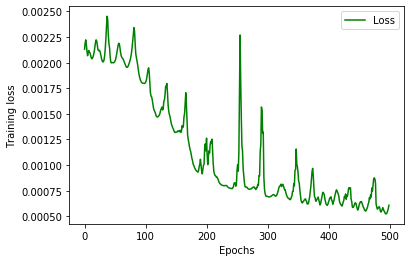

In [17]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

## Encoder Weights Visualization:


In [18]:
# functions to show an image

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

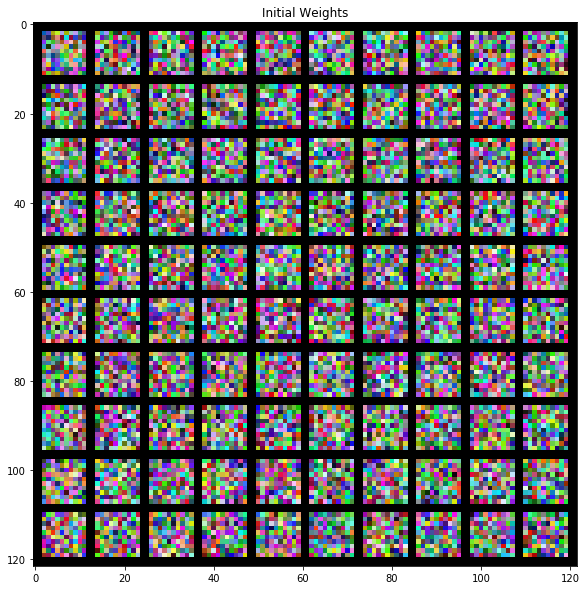

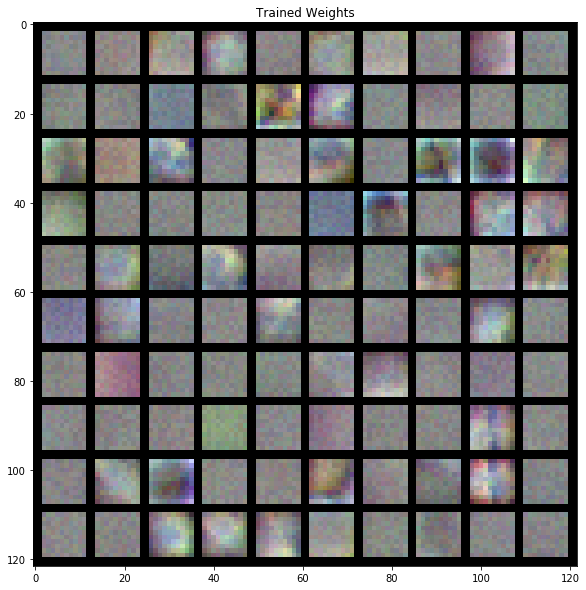

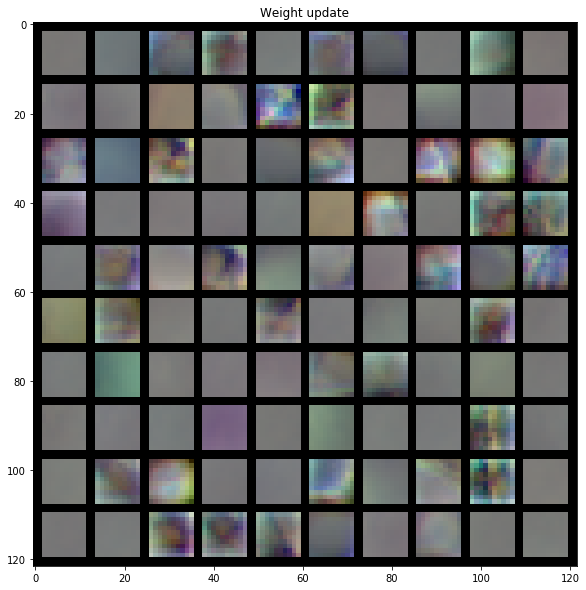

In [19]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)


init_weights = init_weights.view(100,3,10,10)
trained_weights = trained_weights.view(100,3,10,10)

if use_gpu:
    init_weights = init_weights.cpu()
    trained_weights = trained_weights.cpu()

d_weights = init_weights - trained_weights 
d_weights = d_weights.view(100,3,10,10)
    

imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

## Modifying the autoencoder for classification:


In [20]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
net = net.double().to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


## Train Classifier:


In [21]:
criterion = nn.BCELoss()  #binary cross entropy loss ( since, classification) (since, 0/1 labels)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [22]:
iterations = 100 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations): # loop over the dataset multiple times
    runningLoss = 0
    for i in range(int(TrainImages.size()[0]/BatchSize)):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration: 1 / 100  ;  Training Loss: 0.574895 
Finished Training


Text(0, 0.5, 'Training loss')

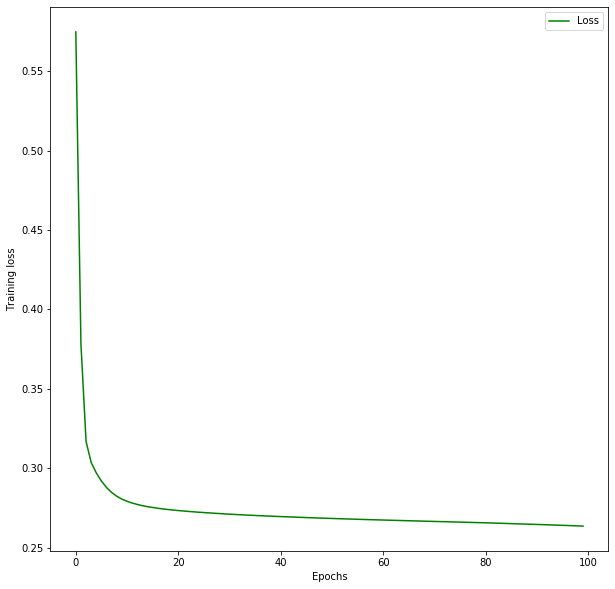

In [23]:
fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss') 

## Testing Performance:


In [24]:
TestDatapath = 'data/retina/test/images/'  # Test Image Data Path
TestLabelpath = 'data/retina/test/1st_manual/'  # Test Image Manual Label

In [ ]:
# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open(TestLabelpath + '01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [ ]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection
#after classification , reconstruct back into original form

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(int(imD.shape[0]/patchH)):
    for j in range(int(imD.shape[1]/patchW)):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(TestTensor.double().to(device))
        if device == "cuda":
            outArr = out.data.cpu()            
        outArr = outArr.numpy()
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]  

In [ ]:
# Display results
plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(imout, 'gray')

plt.figure()
plt.title('Manual Label')
plt.imshow(imL, 'gray')